In [ ]:
import gzip
import gc
import torch
import random
import pickle
import seaborn as sn
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.optim import Adam
from transformers import DistilBertModel, DistilBertTokenizer
from torch.utils.data import DataLoader, Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def data_organizer(type):
    if type == 200:
        f = gzip.open("/content/drive/MyDrive/Hw9/data/sentiment_dataset_train_200.tar.gz", 'rb')
        train_dataset = f.read()
        f = gzip.open("/content/drive/MyDrive/Hw9/data/sentiment_dataset_test_200.tar.gz", 'rb')
        test_dataset = f.read()
    else:
        f = gzip.open("/content/drive/MyDrive/Hw9/data/sentiment_dataset_train_400.tar.gz", 'rb')
        train_dataset = f.read()
        f = gzip.open("/content/drive/MyDrive/Hw9/data/sentiment_dataset_test_400.tar.gz", 'rb')
        test_dataset = f.read()
    positive_reviews_train, negative_reviews_train, vocab = pickle.loads(train_dataset, encoding='latin1')
    positive_reviews_test, negative_reviews_test, vocab = pickle.loads(test_dataset, encoding='latin1')
    indexed_dataset_train, indexed_dataset_test = [], []

    for category in positive_reviews_train:
        for review in positive_reviews_train[category]:
            indexed_dataset_train.append([review, category, 1])
    for category in negative_reviews_train:
        for review in negative_reviews_train[category]:
            indexed_dataset_train.append([review, category, 0])
    random.shuffle(indexed_dataset_train)

    for category in positive_reviews_test:
        for review in positive_reviews_test[category]:
            indexed_dataset_test.append([review, category, 1])
    for category in negative_reviews_test:
        for review in negative_reviews_test[category]:
            indexed_dataset_test.append([review, category, 0])
    random.shuffle(indexed_dataset_test)

    return indexed_dataset_train, indexed_dataset_test

In [ ]:
class TextDataset(Dataset):
    def __init__(self,dataset):
        super(TextDataset,self).__init__()
        self.sentences = []
        self.sentiments = []
        self.one_hot_sentiments = []
        for data in dataset:
            self.sentences.append(data[0])
            self.sentiments.append(data[2])
        self.word_embeddings = self.create_embeddings()
        for i in range(len(self.sentiments)):
            self.one_hot_sentiments.append(self.sentiment_to_one_hot(self.sentiments[i]))

    def create_embeddings(self):
        distilbert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
        distilbert_model = DistilBertModel.from_pretrained('distilbert/distilbert-base-uncased')
        bert_tokenized_sentences_ids = [distilbert_tokenizer.encode(sentence, padding='max_length', truncation=True, max_length=512) for sentence in self.sentences]
        subword_embeddings = []
        for tokens in tqdm(bert_tokenized_sentences_ids):
            input_ids = torch.tensor(tokens).unsqueeze(0)
            with torch.no_grad():
                outputs = distilbert_model(input_ids)
            subword_embeddings.append(outputs.last_hidden_state)
        return subword_embeddings

    def sentiment_to_one_hot(self, sentiment):
        sentiment_tensor = torch.zeros(2)
        if sentiment == 1:
            sentiment_tensor[1] = 1
        elif sentiment == 0:
            sentiment_tensor[0] = 1
        sentiment_tensor = sentiment_tensor.type(torch.long)
        return sentiment_tensor

    def __len__(self):
        return len(self.word_embeddings)

    def __getitem__(self, index):
        #print(self.word_embeddings[index].shape)
        return self.word_embeddings[index], self.one_hot_sentiments[index]

In [ ]:
def createDataLoader(type):
    indexed_dataset_train, indexed_dataset_test = data_organizer(type)
    print('Created Training Set and Testing Set')
    trainDataset = TextDataset(indexed_dataset_train)
    print("Created training dataset")
    testDataset = TextDataset(indexed_dataset_test)
    print("Created testing dataset")
    trainDL = DataLoader(trainDataset, 25, shuffle=True, num_workers=2)
    testDL = DataLoader(testDataset, 25, shuffle=False, num_workers=2)
    print('Created dataloaders')
    return trainDL, testDL

In [ ]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, bidirectional=False):
        super(Model, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=self.bidirectional)
        if(self.bidirectional):
            self.fc = nn.Linear(2*hidden_size, output_size)
        else:
            self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)


    def forward(self, x):
        if(self.bidirectional):
            init_h = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
        else:
            init_h = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
        out, _ = self.gru(x, init_h)
        out = self.fc(self.relu(out[:,-1, :]))
        out = self.logsoftmax(out)
        return out

In [ ]:
def training(net, trainDL, net_path, epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = net.to(device)
    criterion = nn.NLLLoss()
    optimizer = Adam(net.parameters(), lr=1e-3)
    training_losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        count = 0
        for i,data in enumerate(trainDL):
            embedding, sentiment = data
            embedding = embedding.reshape(-1, 512, 768)
            embedding = embedding.to(device)
            sentiment = sentiment.to(device)
            optimizer.zero_grad()
            output = net(embedding)
            loss = criterion(output, torch.argmax(sentiment, dim=1))
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            count += 1
        avg_loss = running_loss / float(count)
        training_losses.append(avg_loss)
        print("[epoch:%d]   loss: %.5f" % (epoch+1, avg_loss))
    torch.save(net.state_dict(), net_path)
    del net
    gc.collect()
    torch.cuda.empty_cache()
    return training_losses

In [ ]:
def validation(net, net_path, testDL):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.load_state_dict(torch.load(net_path))
    net.to(device)
    classification_accuracy = 0.0
    confusion_matrix = torch.zeros(2,2)
    total = 0
    with torch.no_grad():
        for i,data in enumerate(testDL):
            embedding = (data[0].reshape(-1, 512, 768)).to(device)
            sentiment = (data[1]).to(device)
            output = net(embedding)
            predicted_idx = torch.argmax(output.data, 1)
            gt_idx = torch.argmax(sentiment,1)
            for prediction,truth in zip(predicted_idx, gt_idx):
                if prediction == truth:
                    classification_accuracy += 1
                confusion_matrix[truth, prediction] += 1
                total += 1
    print("\nOverall classification accuracy: %0.2f%%" %  (float(classification_accuracy) * 100 /float(total)))
    del net
    gc.collect()
    torch.cuda.empty_cache()
    return confusion_matrix

In [ ]:
trainDL_400, testDL_400 = createDataLoader(400)

Created Training Set and Testing Set


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

100%|██████████| 14227/14227 [22:40<00:00, 10.46it/s]


Created training dataset


100%|██████████| 3563/3563 [05:41<00:00, 10.43it/s]

Created testing dataset
Created dataloaders


In [ ]:
net_400_uni = Model(input_size=768, hidden_size=800, output_size=2, num_layers=2, bidirectional=False)
uni_training_losses_400 = training(net_400_uni, trainDL_400, "/content/drive/MyDrive/Hw9/net_uni_400.pth", 20)
cmatrix_uni_400 = validation(net_400_uni, "/content/drive/MyDrive/Hw9/net_uni_400.pth", testDL_400)

net_400_bi = Model(input_size=768, hidden_size=800, output_size=2, num_layers=2, bidirectional=True)
bi_training_losses_400 = training(net_400_bi, trainDL_400, "/content/drive/MyDrive/Hw9/net_bi_400.pth", 20)
cmatrix_bi_400 = validation(net_400_bi, "/content/drive/MyDrive/Hw9/net_bi_400.pth", testDL_400)

[epoch:1]   loss: 0.59978
[epoch:2]   loss: 0.36953
[epoch:3]   loss: 0.32287
[epoch:4]   loss: 0.27223
[epoch:5]   loss: 0.23422
[epoch:6]   loss: 0.19107
[epoch:7]   loss: 0.14653
[epoch:8]   loss: 0.11619
[epoch:9]   loss: 0.09607
[epoch:10]   loss: 0.08607
[epoch:11]   loss: 0.06265
[epoch:12]   loss: 0.05270
[epoch:13]   loss: 0.05771
[epoch:14]   loss: 0.05069
[epoch:15]   loss: 0.04808
[epoch:16]   loss: 0.04740
[epoch:17]   loss: 0.04221
[epoch:18]   loss: 0.03651
[epoch:19]   loss: 0.04675
[epoch:20]   loss: 0.04376

Overall classification accuracy: 88.13%
[epoch:1]   loss: 0.54538
[epoch:2]   loss: 0.36214
[epoch:3]   loss: 0.31352
[epoch:4]   loss: 0.27455
[epoch:5]   loss: 0.24740
[epoch:6]   loss: 0.20404
[epoch:7]   loss: 0.17026
[epoch:8]   loss: 0.13988
[epoch:9]   loss: 0.10063
[epoch:10]   loss: 0.07586
[epoch:11]   loss: 0.07042
[epoch:12]   loss: 0.05290
[epoch:13]   loss: 0.06942
[epoch:14]   loss: 0.05647
[epoch:15]   loss: 0.03510
[epoch:16]   loss: 0.03763
[epoc

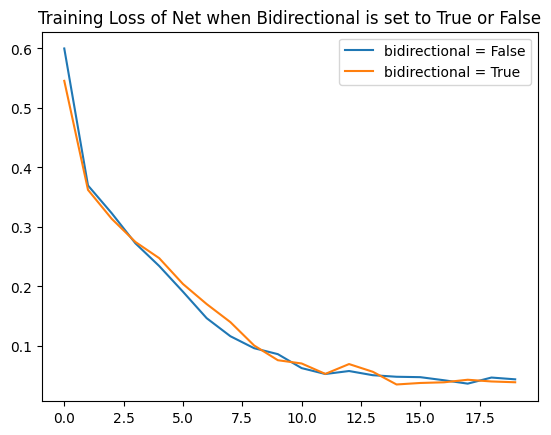

In [ ]:
plt.figure()
plt.title("Training Loss of Net when Bidirectional is set to True or False")
plt.plot(uni_training_losses_400, label="bidirectional = False")
plt.plot(bi_training_losses_400, label="bidirectional = True")
plt.legend()
plt.savefig("/content/drive/MyDrive/Hw9/TrainingLoss_400.png", dpi=400)

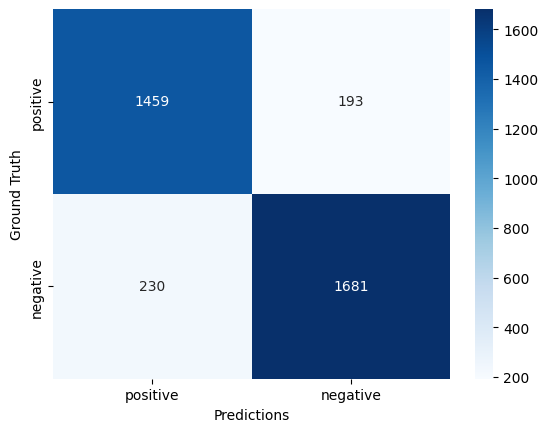

In [ ]:
uni_hm = sn.heatmap(
    data = cmatrix_uni_400,
    cmap = 'Blues',
    annot=True,
    fmt='g',
    xticklabels=['negative', 'positive'],
    yticklabels=['negative', 'positive'],
)
uni_hm.set(xlabel='Predictions', ylabel='Ground Truth')
plt.savefig("/content/drive/MyDrive/Hw9/unidirectional_GRU_cmatrix_400.png", dpi=400)

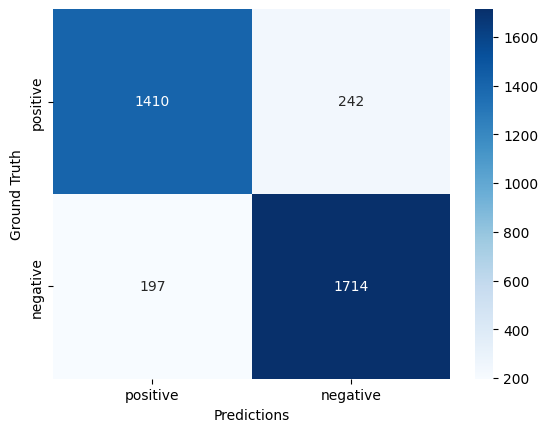

In [ ]:
bi_hm = sn.heatmap(
    data = cmatrix_bi_400,
    cmap = 'Blues',
    fmt='g',
    annot=True,
    xticklabels=['negative', 'positive'],
    yticklabels=['negative', 'positive']
)
bi_hm.set(xlabel='Predictions', ylabel='Ground Truth')
plt.savefig("/content/drive/MyDrive/Hw9/bidirectional_GRU_cmatrix_400.png", dpi=400)